In [407]:
import os
import mpl_toolkits.axes_grid1 as mpl_axes_grid1
import matplotlib
from matplotlib import colors, cm

import numpy as np
import matplotlib.pyplot as plt
def to_complex(mag: np.ndarray, pha: np.ndarray) -> np.ndarray:
    '''from mag, pha to rf'''
    real = np.cos(pha) * mag
    imag = np.sin(pha) * mag
    rf = real + imag * 1j
    return rf

def to_mag_pha(rf: np.ndarray) -> tuple:
    '''from rf to mag, pha'''
    pha = np.angle(rf)
    mag = np.abs(rf)
    return mag, pha

outpath = "{}/out".format(os.getcwd())
if not os.path.exists(outpath):
    os.makedirs(outpath)

In [408]:
nX    = 500
nY    = 500
nRow = 10
nCol = 10
nCoil = nRow*nCol
nBlock = 4
relative_radius = 5
verbose = False

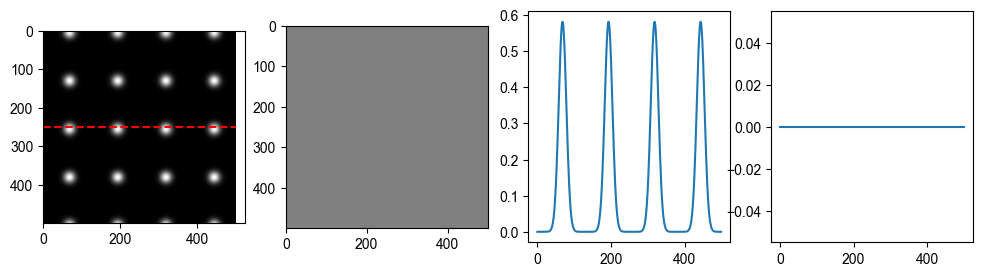

In [409]:
nRowall  = nRow * nBlock
nColall  = nCol * nBlock

sigma = 3
r_x = relative_radius*nX/nRowall/2/sigma
r_y = relative_radius*nY/nColall/2/sigma

centerX = np.linspace(-nX/nBlock, nX*(nBlock+1)/nBlock, nRow*(nBlock+2), endpoint=False) + nX/nRowall/2
centerY = np.linspace(-nY/nBlock, nY*(nBlock+1)/nBlock, nCol*(nBlock+2), endpoint=False) + nY/nColall/2
X, Y = np.meshgrid(np.linspace(0, nX, nX, endpoint=False) + 0.5,np.linspace(0, nY, nY, endpoint=False) + 0.5)
BX, BY = np.meshgrid(np.linspace(0, nRow*(nBlock+2), nBlock+2, endpoint=False, dtype=np.int64),np.linspace(0, nCol*(nBlock+2), nBlock+2, endpoint=False, dtype=np.int64))
csm = np.zeros((nY, nX, nCoil), dtype=np.complex64)
for row in range(nRow):
    for col in range(nCol):
        for i in range(nBlock+2):
            for j in range(nBlock+2):
                x = centerX[BX[i,j]+row]
                y = centerY[BY[i,j]+col]
                mag = np.exp(-(((X-x)/r_x)**2 + ((Y-y)/r_y)**2)/2)
                csm[:, :, row*nCol+col] += mag
        # pha = np.angle((X -  x) + 1j*(Y - y))
        # pha = np.exp(-(((X-x)/(5*nX/2/sigma))**2 + ((Y-y)/(5*nY/2/sigma))**2)/2) * 2*np.pi - np.pi
        # pha = np.sqrt((X-x)**2 + (Y-y)**2)/(np.minimum(nX/nRow/2, nY/nCol/2))**2 * np.pi
        # pha = pha if (row+col) % 2 == 0 else -pha 
        # csm[:, :, row*nRow+col] = to_complex(csm[:, :, row*nCol+col], pha)

norm = np.sqrt(np.sum(np.abs(csm)**2, axis=2))
csm = np.transpose(csm, (2, 0, 1)) / norm

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(np.abs(csm[nCoil//2, ...]), cmap='gray')
axs[0].hlines(nX//2, 0, nY, colors='r', linestyles='--')
axs[1].imshow(np.angle(csm[nCoil//2, ...]), cmap='gray', vmin=-np.pi, vmax=np.pi)
axs[2].plot(np.abs(csm[nCoil//2, nX//2, :]))
axs[3].plot(np.angle(csm[nCoil//2, nX//2, :]))
plt.show()

In [410]:
matplotlib.rc("font", family="Arial")
matplotlib.rcParams['mathtext.default'] = 'regular'
values = np.linspace(1, nRow*nCol, nRow*nCol, dtype=np.int32)
cm_gray = plt.get_cmap("jet")
cm_gray_ref = cm_gray.from_list("gray_ref",  cm_gray(values), len(values))
norm = colors.BoundaryNorm(values , cm_gray_ref.N)

figure_width       = 12/2.53999863
figure_height      = 5/2.53999863

color_facecolor    = "#ffffff"
color_label        = "#000000"

fontsize_label     = 7
fontsize_ticklabel = 6
fontsize_ticklabel_cb = 5
fontsize_subfigure = 9

markersize_scatter = 2
linewidth          = 0.5
ticklength         = 1.5

pad_labeltick      = 2
pad_label          = 4

cmap_block         = "viridis" # "magma" #"viridis"

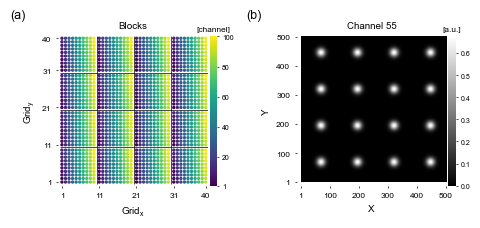

In [411]:
fig, axs = plt.subplots(1, 2, figsize=(figure_width, figure_height), squeeze=False, facecolor=color_facecolor)
ax1 = axs[0][0]
ax2 = axs[0][1]

for ax in [ax1, ax2]:
    ax.set_facecolor(color_facecolor)
    ax.tick_params(axis="both",color=color_label, labelcolor=color_label, labelsize=fontsize_ticklabel, length=ticklength, width=linewidth)
    for spine in ax.spines:  # "left", "right", "bottom", "top"
        ax.spines[spine].set_color(color_label)
        # ax.spines[spine].set_linewidth(linewidth)
        ax.spines[spine].set_visible(False)
    ax.axis('equal')

scatter_X = np.array([],  dtype=np.int64)
scatter_Y = np.array([],  dtype=np.int64)
scatter_C = np.array([],  dtype=np.int64)
block_shift = (np.linspace(1, nBlock, nBlock, dtype=np.int16)-1) / 2
block_shift_2d = np.stack([block_shift for i in range(nBlock)])
for i in range(nRow):
    for j in range(nCol):
        scatter_X = np.append(scatter_X, (BX[:-2,:-2]+i+block_shift_2d).flatten()+1)
        scatter_Y = np.append(scatter_Y, (BY[:-2,:-2]+j+block_shift_2d.T).flatten()+1)
        scatter_C = np.append(scatter_C, np.ones((nBlock)**2)*(i*nCol+j+1))

im1 = ax1.scatter(scatter_X, scatter_Y, c=scatter_C, s=markersize_scatter, cmap=cmap_block , vmin=1, vmax=nRow*nCol+1)


ax1.set_title("Blocks", fontsize=fontsize_label, color=color_label)
ax1.set_ylabel(r"$Grid_{y}$", fontsize=fontsize_label, color=color_label)
ax1.set_xlabel(r"$Grid_{x}$", fontsize=fontsize_label, color=color_label)
ax1.set_ylim(0, nCol*nBlock+0.5+(nBlock-1)/2)
ax1.set_xlim(0, nRow*nBlock+0.5+(nBlock-1)/2)

block_ticks_x = np.linspace(0, nCol*nBlock, nBlock+1, dtype=np.int8)+1
block_ticks_y = np.linspace(0, nRow*nBlock, nBlock+1, dtype=np.int8)+1
block_ticks_x[-1] = nCol*nBlock
block_ticks_y[-1] = nRow*nBlock
ax1.xaxis.set_ticks(block_ticks_x + np.append(block_shift, block_shift[-1]))
ax1.yaxis.set_ticks(block_ticks_y + np.append(block_shift, block_shift[-1]))
ax1.xaxis.set_ticklabels(block_ticks_x)
ax1.yaxis.set_ticklabels(block_ticks_y)
ax1.hlines(block_ticks_x[1:-1] + block_shift[1:] - block_shift[1]/2 - 0.5, 0.5, nRow*nBlock+0.5+(nBlock-1)/2, linewidth=linewidth, color=color_label)
ax1.vlines(block_ticks_y[1:-1] + block_shift[1:] - block_shift[1]/2 - 0.5, 0.5, nCol*nBlock+0.5+(nBlock-1)/2, linewidth=linewidth, color=color_label)



ax2.set_title(f"Channel {nCoil//2 + nCol//2}", fontsize=fontsize_label, color=color_label)
ax2.set_ylabel("Y", fontsize=fontsize_label, color=color_label)
ax2.set_xlabel("X", fontsize=fontsize_label, color=color_label)
im2 = ax2.imshow(np.abs(csm[nCoil//2 + nCol//2, ...]), cmap='gray')

ax2.set_ylim(-nY/(nRow*nBlock), nY)
ax2.set_xlim(-nX/(nCol*nBlock), nX)

ticks_x = np.linspace(0, nX, 5+1, dtype=np.int16, endpoint=True) - 1
ticks_y = np.linspace(0, nY, 5+1, dtype=np.int16, endpoint=True) - 1
ticks_x[0] = 0
ticks_y[0] = 0
ax2.xaxis.set_ticks(ticks_x)
ax2.yaxis.set_ticks(ticks_y)
ax2.xaxis.set_ticklabels(1+ticks_x)
ax2.yaxis.set_ticklabels(1+ticks_y)


divider = mpl_axes_grid1.make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.02)
cax.set_title("[channel]", fontsize=fontsize_ticklabel, color=color_label, pad=pad_label)
cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=1, vmax=nRow*nCol), cmap=cmap_block), cax=cax)
cb.ax.tick_params(color=color_label, labelcolor=color_label, labelsize=fontsize_ticklabel_cb,length=ticklength, width=linewidth, pad=pad_labeltick)
block_cb_ticks = np.linspace(0, nRow*nCol, 5+1, dtype=np.int8, endpoint=True)
block_cb_ticks[0] = 1
cb.set_ticks(block_cb_ticks)
cb.outline.set_visible(False)
cb.update_ticks()

divider = mpl_axes_grid1.make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.02)
cax.set_title("[a.u.]", fontsize=fontsize_ticklabel, color=color_label, pad=pad_label)
cb = fig.colorbar(im2, cax=cax)
cb.ax.tick_params(color=color_label, labelcolor=color_label, labelsize=fontsize_ticklabel_cb,length=ticklength, width=linewidth, pad=pad_labeltick)
cb.outline.set_visible(False)
cb.update_ticks()


fig.text(0.0, 1, "(a)", ha="left", va="bottom", fontsize=fontsize_subfigure, color=color_label)
fig.text(0.5, 1, "(b)", ha="left", va="bottom", fontsize=fontsize_subfigure, color=color_label)

fig.tight_layout(pad=0, h_pad=0, w_pad=0.3)

fig.savefig(f"{outpath}/FigS3.png", dpi=900, transparent=False, bbox_inches="tight", pad_inches=0.05)
fig.savefig(f"{outpath}/FigS3.svg", dpi=900, transparent=False, bbox_inches="tight", pad_inches=0.05)